### import libraries and set dependency

In [2]:
import pandas as pd
import numpy as np
import xgboost
import warnings
import keras
from sklearn import metrics
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
pd.set_option('max_columns', None)
pd.set_option('max_rows',None)
pd.set_option('display.max_colwidth', 200)

### Reading Train & Test Dataset and appending both in a single dataframe

In [24]:
train = pd.read_csv("DS_ML Coding Challenge Dataset - Training Dataset.csv")
train['flag'] = 'train'
train = train.drop_duplicates()
print("train data shape:", train.shape)

test = pd.read_csv("DS_ML Coding Challenge Dataset - Test Dataset.csv")
test['flag'] = 'test'
test = test.drop_duplicates()
print("test data shape:", test.shape)

df = pd.concat([train,test])
df['Date'] = pd.to_datetime(df['Month of Sourcing'], format="%b-%y")
df = df.drop_duplicates()
print("total dataset shape:", df.shape)
df.head(100)

train data shape: (7380, 9)
test data shape: (96, 9)
total dataset shape: (7476, 10)


,ProductType,Manufacturer,Area Code,Sourcing Channel,Product Size,Product Type,Month of Sourcing,Sourcing Cost,flag,Date
0,NTM3,X1,A28,WHOLESALE,Large,Powder,May-21,10.16,train,2021-05-01
1,NTM2,X1,A9,DIRECT,Large,Powder,Oct-20,134.28,train,2020-10-01
2,NTM3,X2,A20,DIRECT,Large,Powder,Dec-20,12.46,train,2020-12-01
3,NTM3,X1,A18,WHOLESALE,Small,Powder,Feb-21,107.22,train,2021-02-01
4,NTM2,X1,A28,DIRECT,Large,Liquid,Nov-20,197.76,train,2020-11-01
5,NTM1,X1,A10,DIRECT,Large,Powder,Sep-20,137.93,train,2020-09-01
6,NTM2,X1,A19,DIRECT,Large,Powder,Sep-20,105.59,train,2020-09-01
7,NTM2,X1,A29,DIRECT,Small,Powder,Mar-21,90.78,train,2021-03-01
8,NTM3,X1,A18,RETAIL,Large,Liquid,Nov-20,154.04,train,2020-11-01
9,NTM3,X2,A20,DIRECT,Large,Powder,Mar-21,85.71,train,2021-03-01


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7476 entries, 0 to 95
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ProductType        7476 non-null   object        
 1   Manufacturer       7476 non-null   object        
 2   Area Code          7476 non-null   object        
 3   Sourcing Channel   7476 non-null   object        
 4   Product Size       7476 non-null   object        
 5   Product Type       7476 non-null   object        
 6   Month of Sourcing  7476 non-null   object        
 7   Sourcing Cost      7476 non-null   float64       
 8   flag               7476 non-null   object        
 9   Date               7476 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 642.5+ KB


# Exploratory Data Analysis:
1. Check for Missing Values
2. Check number of Numerical Variables
3. Distribution of the Numerical Variables
4. Check for Categorical Variables
5. Cardinality of Categorical Variables
6. Temporal variables
7. Check for Outliers
8. Relationship between independent and dependent feature (Sourcing Cost)

### check missing values (numbers & visual)

In [5]:
#check missing and null values
df.isnull().sum()

ProductType          0
Manufacturer         0
Area Code            0
Sourcing Channel     0
Product Size         0
Product Type         0
Month of Sourcing    0
Sourcing Cost        0
flag                 0
Date                 0
dtype: int64

<AxesSubplot:>

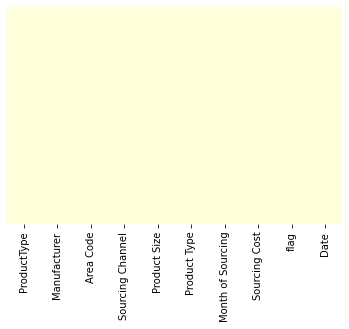

In [6]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='YlGnBu')


### Numerical Variables

In [7]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))
df[numerical_features].head()

Number of numerical variables:  2


,Sourcing Cost,Date
0,10.16,2021-05-01
1,134.28,2020-10-01
2,12.46,2020-12-01
3,107.22,2021-02-01
4,197.76,2020-11-01


In [8]:
df['Sourcing Cost'].describe()

count     7476.000000
mean       150.114869
std        577.220695
min       -196.070000
25%         58.650000
50%        118.195000
75%        145.782500
max      32632.500000
Name: Sourcing Cost, dtype: float64

In [9]:
print(df['Month of Sourcing'].unique())

['May-21' 'Oct-20' 'Dec-20' 'Feb-21' 'Nov-20' 'Sep-20' 'Mar-21' 'Jan-21'
 'Apr-21' 'Jul-20' 'Aug-20' 'Jun-21']


### Relation between data and Cost Plot

Text(0.5, 1.0, 'Sourcing Cost vs MonthSold')

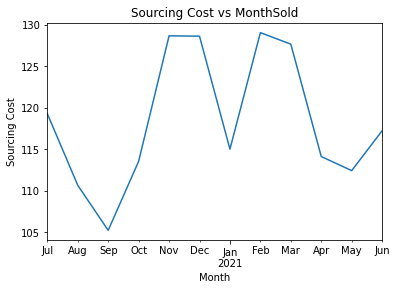

In [10]:
df.groupby('Date')['Sourcing Cost'].median().plot()
plt.xlabel('Month')
plt.ylabel('Sourcing Cost')
plt.title("Sourcing Cost vs MonthSold")

### Categorical Features

In [11]:
categorical_features=[feature for feature in df.columns if df[feature].dtypes=='O']
print ("Categorical Features:", categorical_features)

for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(df[feature].unique())))

Categorical Features: ['ProductType', 'Manufacturer', 'Area Code', 'Sourcing Channel', 'Product Size', 'Product Type', 'Month of Sourcing', 'flag']
The feature is ProductType and number of categories are 3
The feature is Manufacturer and number of categories are 3
The feature is Area Code and number of categories are 45
The feature is Sourcing Channel and number of categories are 4
The feature is Product Size and number of categories are 3
The feature is Product Type and number of categories are 2
The feature is Month of Sourcing and number of categories are 12
The feature is flag and number of categories are 2


### Visualize Categorical Variables wrt Records

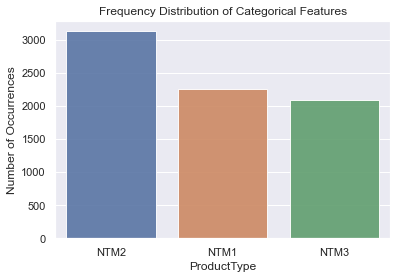

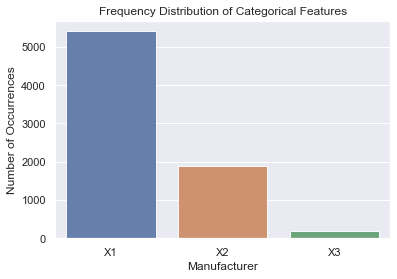

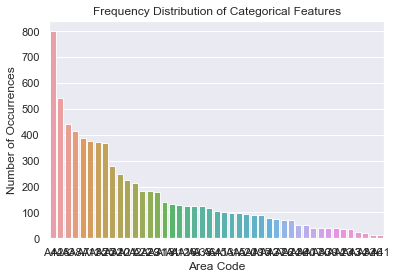

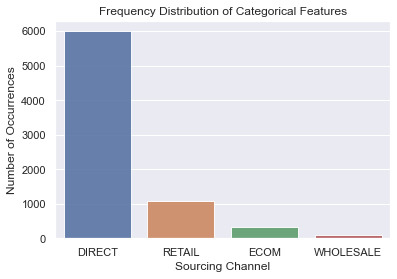

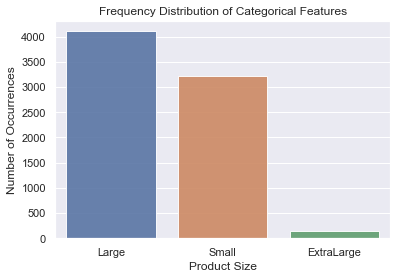

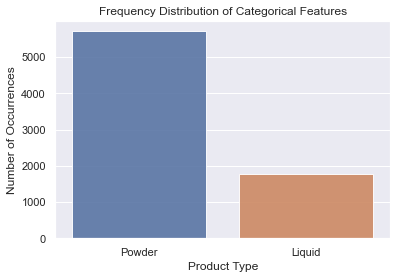

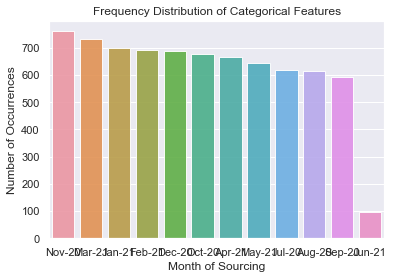

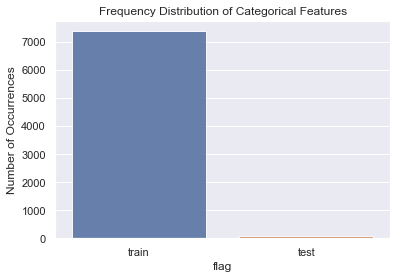

In [12]:
for feature in categorical_features:
    data=df.copy()
    count = df[feature].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(count.index, count.values, alpha=0.9)
    plt.title('Frequency Distribution of Categorical Features')
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.show()

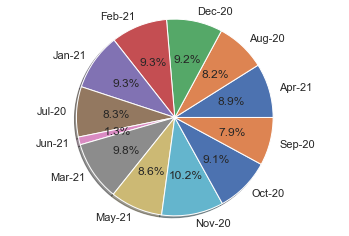

In [13]:
labels = df['Month of Sourcing'].astype('category').cat.categories.tolist()
counts = df['Month of Sourcing'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

### Relationship between categorical variable and dependent feature "Sourcing Cost"


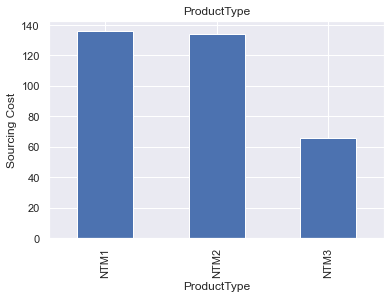

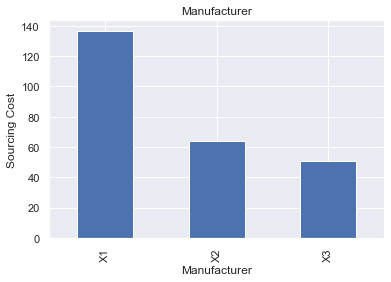

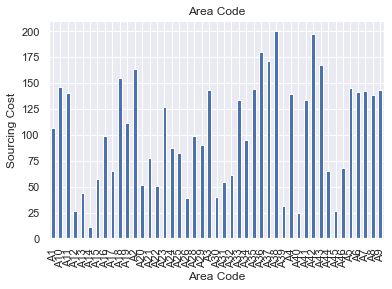

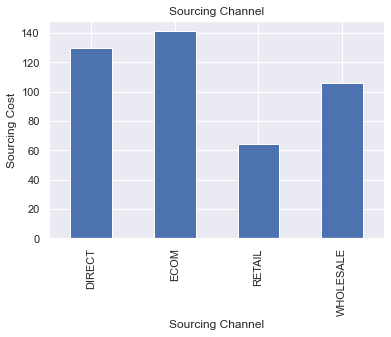

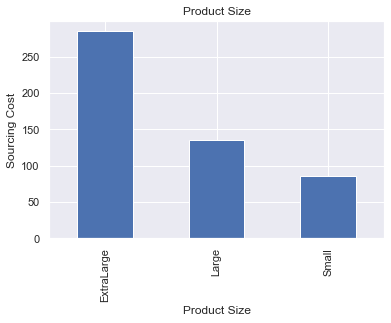

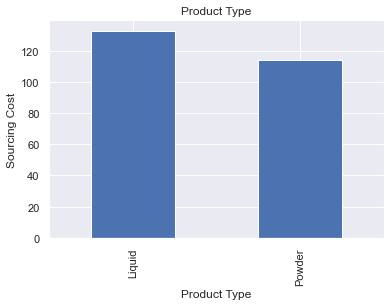

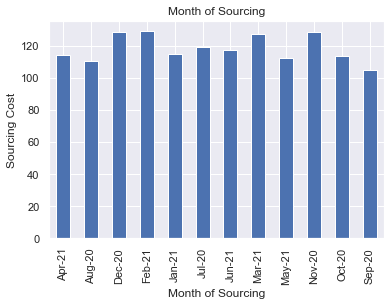

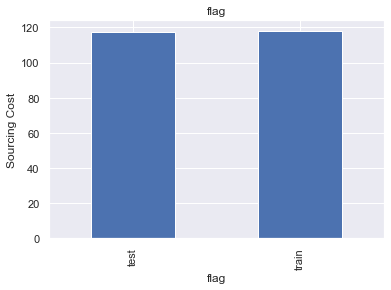

In [14]:
for feature in categorical_features:
    data=df.copy()
    data.groupby(feature)['Sourcing Cost'].median().plot.bar()
    plt.xlabel(feature)
    plt.ylabel('Sourcing Cost')
    plt.title(feature)
    plt.show()

### Detecting outliers

<AxesSubplot:xlabel='Sourcing Cost'>

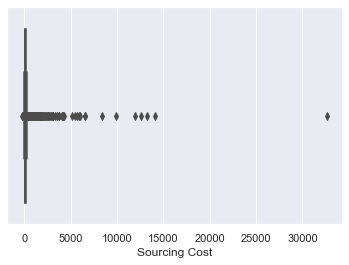

In [15]:
sns.boxplot(df['Sourcing Cost'])

## Feature Engineering

1. Encoding of Categorical Features if any (Label, One-hot encoding)
2. Feature Scaling for Numerical Variables if any (Standard Scalar, min-max scalar)
3. Removing Outliers (Z-score, Inter-Quartile Range (IQR), percentile-based approach based on data distribution) 

### outliers removal techniques

In [16]:
df['Sourcing Cost'].describe()

count     7476.000000
mean       150.114869
std        577.220695
min       -196.070000
25%         58.650000
50%        118.195000
75%        145.782500
max      32632.500000
Name: Sourcing Cost, dtype: float64

### Capping outliers by Inter-Quartile Range

In [17]:
##  Way 1 : Inter-Quartile Range outliers

percentile25 = df['Sourcing Cost'].quantile(0.25)
percentile75 = df['Sourcing Cost'].quantile(0.75)

print("25 percentile:", percentile25)
print("75 percentile:", percentile75)

iqr = percentile75 - percentile25 
print("Inter-Quartile Range:", iqr)

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("upper limit:", upper_limit)
print("lower limit:", lower_limit)

df['Sourcing Cost'] = np.where(
    df['Sourcing Cost'] > upper_limit,
    upper_limit,
    np.where(
        df['Sourcing Cost'] < lower_limit,
        lower_limit,
        df['Sourcing Cost']
    )
)
df['Sourcing Cost'].describe()

25 percentile: 58.65
75 percentile: 145.7825
Inter-Quartile Range: 87.1325
upper limit: 276.48125
lower limit: -72.04874999999998


count    7476.000000
mean      108.935739
std        64.297718
min       -72.048750
25%        58.650000
50%       118.195000
75%       145.782500
max       276.481250
Name: Sourcing Cost, dtype: float64

### Plot after removal of outliers

<AxesSubplot:xlabel='Sourcing Cost'>

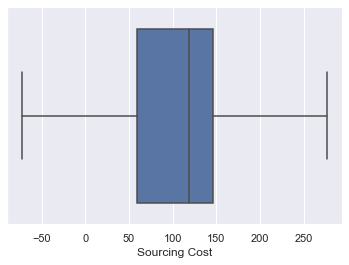

In [18]:
sns.boxplot(df['Sourcing Cost'])

### Categorical Variables Encoding

In [19]:
le= LabelEncoder()

dfdummies = pd.get_dummies(data=df,columns=['ProductType','Manufacturer','Sourcing Channel','Product Size','Product Type','Month of Sourcing'])
dfdummies['Area Code'] = le.fit_transform(dfdummies['Area Code'])
dfdummies.head()

,Area Code,Sourcing Cost,flag,Date,ProductType_NTM1,ProductType_NTM2,ProductType_NTM3,Manufacturer_X1,Manufacturer_X2,Manufacturer_X3,Sourcing Channel_DIRECT,Sourcing Channel_ECOM,Sourcing Channel_RETAIL,Sourcing Channel_WHOLESALE,Product Size_ExtraLarge,Product Size_Large,Product Size_Small,Product Type_Liquid,Product Type_Powder,Month of Sourcing_Apr-21,Month of Sourcing_Aug-20,Month of Sourcing_Dec-20,Month of Sourcing_Feb-21,Month of Sourcing_Jan-21,Month of Sourcing_Jul-20,Month of Sourcing_Jun-21,Month of Sourcing_Mar-21,Month of Sourcing_May-21,Month of Sourcing_Nov-20,Month of Sourcing_Oct-20,Month of Sourcing_Sep-20
0,19,10.16,train,2021-05-01,0,0,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,44,134.28,train,2020-10-01,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,12,12.46,train,2020-12-01,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,9,107.22,train,2021-02-01,0,0,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,19,197.76,train,2020-11-01,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0


## Feature Selection and Model Building

1. Divide dataset into Train & Test
2. Separation of Prediction Variable
3. Run ML Algorithm with Hyper-parameter Tuning to decide best estimators for the model
4. Train model with final parameters

### Train Test split

In [20]:
df = dfdummies

train = df[df['flag']=='train']
train = train.drop(['flag','Date'], axis=1)
print("train shape:", train.shape)

test = df[df['flag']=='test']
test = test.drop(['flag','Date'], axis=1)
print("test shape:", test.shape)

print("Dependent variable location:", train.columns.get_loc("Sourcing Cost"))

X_train = train.iloc[:,train.columns!='Sourcing Cost']
y_train = train.iloc[:,1]

X_test = test.iloc[:,test.columns!='Sourcing Cost']
y_test = test.iloc[:,1]
print("X_train and y_train shape:", X_train.shape, y_train.shape)
print("X_test and y_test shape:", X_test.shape, y_test.shape)

train shape: (7380, 29)
test shape: (96, 29)
Dependent variable location: 1
X_train and y_train shape: (7380, 28) (7380,)
X_test and y_test shape: (96, 28) (96,)


### Model Building

### Approach 1 (Random Forest with Hyper-parameter Tuning)

### Why Random Forest?
1. works best for non linear data points
2. Random Forest does not overfit

#### Randomized Search CV and selecting best parameters

In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['mse','mae']}
print("Random grid:", random_grid)

rf=RandomForestRegressor()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=10,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_train,y_train)
print("Best parameters:", rf_randomcv.best_params_)

Random grid: {'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['mse', 'mae']}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'n_estimators': 2000, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'criterion': 'mse'}


### model fit & predict & check performance

In [23]:
model=RandomForestRegressor(n_estimators = 2000, min_samples_split = 14, min_samples_leaf = 2, max_features = 'auto', max_depth = 10, criterion = 'mse', random_state = 10)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

r2 = r2_score(y_test,y_pred)
print("r2 score:", r2)

RMSE: 36.713
MAE: 20.586
r2 score: 0.5031911833619614


### Approach 2 (XGBoost Algorithm)  (Best Approach)


In [14]:
model=xgboost.XGBRegressor(n_estimators = 1000, random_state = 10)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

r2 = r2_score(y_test,y_pred)
print("r2 score:", r2)

RMSE: 35.313
MAE: 19.183
0.5403406659793103


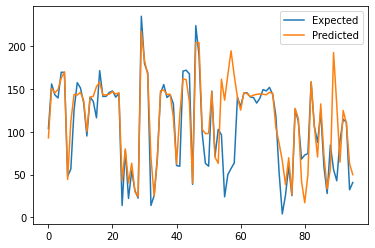

In [24]:
pyplot.plot(y_test, label='Expected')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

# why xgboost?
1. XGBoost giving lowest RMSE and MAE among 3 approaches.
2. Works best for small datasets
3. Works best without hyperparameter tuning

### Neural Network Implementation (Approach 3)

## why Neural Network?
1. Good Fault Tolerance (output is not affected by corruption of one or more than one cell of NN)

In [30]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [31]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(output_dim = 50, init = 'he_uniform',activation='relu',input_dim = 28))

# Adding the second hidden layer
classifier.add(Dense(output_dim = 25, init = 'he_uniform',activation='relu'))

# Adding the third hidden layer
classifier.add(Dense(output_dim = 50, init = 'he_uniform',activation='relu'))
# Adding the output layer
classifier.add(Dense(output_dim = 1, init = 'he_uniform'))

# Compiling the ANN
classifier.compile(loss=root_mean_squared_error, optimizer='Adam')

# Fitting the ANN to the Training set
model_history=classifier.fit(X_train.values, y_train.values,validation_split=0.20, batch_size = 10, nb_epoch = 100)


Train on 5904 samples, validate on 1476 samples
Epoch 1/100
5904/5904 [==============================] - 1s 204us/step - loss: 63.3187 - val_loss: 64.1379
Epoch 2/100
5904/5904 [==============================] - 1s 126us/step - loss: 49.6728 - val_loss: 64.0320
Epoch 3/100
5904/5904 [==============================] - 1s 144us/step - loss: 48.5591 - val_loss: 63.7995
Epoch 4/100
5904/5904 [==============================] - 1s 146us/step - loss: 47.6057 - val_loss: 62.6867
Epoch 5/100
5904/5904 [==============================] - 1s 146us/step - loss: 46.7066 - val_loss: 61.5834
Epoch 6/100
5904/5904 [==============================] - 1s 140us/step - loss: 46.2368 - val_loss: 61.1740
Epoch 7/100
5904/5904 [==============================] - 1s 166us/step - loss: 45.3440 - val_loss: 61.4034
Epoch 8/100
5904/5904 [==============================] - 1s 211us/step - loss: 45.0698 - val_loss: 60.2170
Epoch 9/100
5904/5904 [==============================] - 1s 201us/step - loss: 44.5364 - val_los

In [32]:
y_pred = classifier.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae)

r2 = r2_score(y_test,y_pred)
print("r2 score:", r2)

RMSE: 39.777
MAE: 27.873
0.41678341808685815
